# Inroduction

Useful links:
- Intorduction to Quantization on PyTorch https://pytorch.org/blog/introduction-to-quantization-on-pytorch/
- PyTorch modules that provide quantization classes and functions https://pytorch.org/docs/stable/quantization.html#modules-that-provide-quantization-functions-and-classes

In [132]:
! pip install tensorly

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict
import copy
import os

In [134]:
import tensorly as tl
tl.set_backend('pytorch')

# Task 1 [2 points]

For X = DD + MM + YY + YY, where DD/MM/YYYY is your date of birth  

1. Represent the number X in the following formats:

  a) int8,  big-endian

  b) int8, little-endian

  c) int16, big-endian

  d) int16, little-endian

  e) float32, big-endian

  f) float32, little-endian

2. Write representations in the same formats a)-e) for -X


Use the following style when writing/printing:

- For all cases: 8 bits - space - 8 bits - space - ...

- Additionally, for float big-endian format print the result the following ways: 

  - sign bit - space - exponent bits - space - fraction bits

  - sign multiplier - space - exponent multiplier - space - faction multiplier (all multipliers in float format, multiply them to check whether the result is close to the initial number)  



In [135]:
x = 14 + 8 + 19 + 99
x

140

In [136]:
import struct

In [137]:
def get_binary(v, fmt = 'f', input_type = None, return_type = None):
  if input_type != 'hex':
    v_packed = struct.pack('{}'.format(fmt), v)
    # print(v_packed)
  else:
    return v_packed

  v_binaries = [bin(i) for i in v_packed]
#   print(v_binaries)

  v_binaries_stripped = [s.replace('0b', '') for s in v_binaries]
  # print(v_binaries_stripped)

  v_padded = [s.rjust(8, '0') for s in v_binaries_stripped]
#   print(v_padded)

  if fmt == '!f' and 'float' in v.__class__.__name__:
    tmp = ''.join(v_padded)
    a, b, c = tmp[0], tmp[1:9], tmp[9:]

    return ' '.join([a, b, c])   

  return ' '.join(v_padded)

In [138]:
from math import pow, inf, nan

def combine_str_realnumber_parts(sign: str, exponent: str, fraction: str):
  """
  Input: sign, exponent and fraction are the parts of binary representation of 
  floating point number.
  """

  s = ''.join([sign, exponent, fraction])
  assert set(s) == set(['0', '1']), "Strings should contain only '0' and '1'"

  sign = 1. if sign == '0' else -1.

  if set(exponent) == set('1'):     # exponent is consist of only ones
    if set(fraction) == set('0'):   # fraction is consist of only zeros
      return sign * inf             # +- Infinity
    else:
      return nan                    # Not a Number

  elif set(exponent) == set('0'):   # exponent is consist of only zeros
    if set(fraction) == set('0'):   # fraction is consist of only zeros
      return sign * 0               # +-0
    else:
      exp_multiplier = pow(2, 2 - (1<<len(exponent)-1))
      frac_multiplier = int(fraction, 2) * 1. / (1<<len(fraction))
      return sign * exp_multiplier * frac_multiplier    # Subnormal number (very small)
  

  exp_bias = 1 - (1<<(len(exponent)-1))
  print(f"2^(len(exponent)-1)-1 = {-exp_bias}")
  exp_multiplier_tmp = int(exponent, 2) + exp_bias
  print(f"2^(exponent{exp_bias}) = 2^{exp_multiplier_tmp}")

  exp_multiplier = pow(2, exp_multiplier_tmp)
  frac_part = int(fraction, 2) * 1. / (1<<len(fraction))
  print(f"1.fraction = {1+frac_part}")
  frac_multiplier = 1. + frac_part
  return sign * exp_multiplier * frac_multiplier  # Normal number (very small)
  

In [139]:
import numpy as np

**a) int8, big-endian**

1.

In [140]:
get_binary(np.int8(x), fmt='!f')

'11000010 11101000 00000000 00000000'

2.

In [141]:
get_binary(np.int8(-x), fmt='!f')

'01000010 11101000 00000000 00000000'

**b) int8, little-endian**

1.

In [142]:
get_binary(np.int8(x))

'00000000 00000000 11101000 11000010'

2.

In [143]:
get_binary(np.int8(-x))

'00000000 00000000 11101000 01000010'

**c) int16, big-endian**

1.

In [144]:
get_binary(np.int16(x), fmt='!f')

'01000011 00001100 00000000 00000000'

2.

In [145]:
get_binary(np.int16(-x), fmt='!f')

'11000011 00001100 00000000 00000000'

**d) int16, little-endian**

1.

In [146]:
get_binary(np.int16(x))

'00000000 00000000 00001100 01000011'

2.

In [147]:
get_binary(np.int16(-x))

'00000000 00000000 00001100 11000011'

**e) float32, big-endian**

1.

In [148]:
bin_v = get_binary(np.float32(x), fmt='!f')
bin_v

'0 10000110 00011000000000000000000'

In [149]:
combine_str_realnumber_parts(*bin_v.split(' '))

2^(len(exponent)-1)-1 = 127
2^(exponent-127) = 2^7
1.fraction = 1.09375


140.0

2.

In [150]:
bin_v = get_binary(np.float32(-x), fmt='!f')
bin_v

'1 10000110 00011000000000000000000'

In [151]:
combine_str_realnumber_parts(*bin_v.split(' '))

2^(len(exponent)-1)-1 = 127
2^(exponent-127) = 2^7
1.fraction = 1.09375


-140.0

**f) float32, little-endian**

1.

In [152]:
get_binary(np.float32(x))

'00000000 00000000 00001100 01000011'

2.

In [153]:
get_binary(np.float32(-x))

'00000000 00000000 00001100 11000011'

# Task 2 [4 point]

Given tensor X and using PyTorch tools


1. Implement per-tensor affine quantization :

  a) int8 symmetric 

  b) uint8 symmetric 

  c) int8 assymmetric

  You'll need to do that for several given input tensors.
  
  - What can you say by comparing approximation errors of a)-c) representations? 

  - Explain why some quantization schemes suit better for some inputs.

2. Implement per-tensor and per-channel (along axis = 0) affine quantization using int8 symmetric quantization.

  You'll need to do that for several given input tensors.

  - What can you say  by comparing approximation errors for per-tensor and per-channel quantization  for different inputs? 

  - Explain why some quantization schemes suit better for some inputs.


Useful links:

- Quantized Tensors in PyTorch: https://pytorch.org/docs/stable/quantization.html#quantized-tensors


## Demostrative Example

Pay attention to types of tensors when performing quantization / dequantization using PyTorch tools


In [154]:
# Generate a float tensor
t = torch.arange(512).reshape(32, 16) + torch.randn((32, 16))

print(f'After generation: \n\t type: {t.dtype}, \n\n\t tesor: {t[0, :]}')

# Quantize the tensor
qt = torch.quantize_per_tensor(t, scale=1.5, zero_point=0, dtype=torch.qint8)

print(f'\n\nAfter quantization: \n\t type: {qt.dtype},'+
      f'\n\n\t quantized tensor in float representation: {qt[0, :]},'+
      f' \n\n\t quantized tensor in int representation: {qt.int_repr()[0, :]}')

# Dequantize the tensor
dqt = qt.dequantize()

print(f'\n\nAfter dequantization: \n\t type: {dqt.dtype}, \n\n\t dequantized tesor: {dqt[0, :]}')


After generation: 
	 type: torch.float32, 

	 tesor: tensor([ 1.3892,  3.8885,  1.5940,  3.2478,  3.7736,  3.0347,  6.2459,  7.1071,
         8.0800,  9.3021,  9.5425, 12.0443,  9.7773, 12.3405, 13.9883, 14.0674])


After quantization: 
	 type: torch.qint8,

	 quantized tensor in float representation: tensor([ 1.5000,  4.5000,  1.5000,  3.0000,  4.5000,  3.0000,  6.0000,  7.5000,
         7.5000,  9.0000,  9.0000, 12.0000, 10.5000, 12.0000, 13.5000, 13.5000],
       size=(16,), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=1.5, zero_point=0), 

	 quantized tensor in int representation: tensor([1, 3, 1, 2, 3, 2, 4, 5, 5, 6, 6, 8, 7, 8, 9, 9], dtype=torch.int8)


After dequantization: 
	 type: torch.float32, 

	 dequantized tesor: tensor([ 1.5000,  4.5000,  1.5000,  3.0000,  4.5000,  3.0000,  6.0000,  7.5000,
         7.5000,  9.0000,  9.0000, 12.0000, 10.5000, 12.0000, 13.5000, 13.5000])


In [155]:
# Print scale and zero_point
try:
  print(qt.q_scale(), qt.q_zero_point())
except:
  print(qt.q_per_channel_scales(), qt.q_zero_points())

1.5 0


## Task 2.0 Implement Quantization / Dequantization [2 point]

In [156]:
def quantize_tensor(x, torch_dtype, is_symmetric=True, is_per_channel=False, axis = 0):
  if is_per_channel:
    x_quantized = quantize_tensor_per_channel(x, torch_dtype, is_symmetric, axis)

  else:
    x_quantized = quantize_tensor_per_tensor(x, torch_dtype, is_symmetric)

  return x_quantized

### Per Tensor Quantization. Fill the blanks in the code.

In [157]:
def quantize_tensor_per_tensor(x, torch_dtype, is_symmetric=True):

    print(f"\nQuantization type: {torch_dtype}, symmetric: {is_symmetric}, per_channel: {False} ")

    bits = torch.iinfo(torch_dtype).bits

    # Minimum  and maximum quantization values
    if torch_dtype == torch.qint8: # torch.iinfo(torch_dtype).min != 0 
      quant_min = -2**(bits - 1) 
      quant_max = 2**(bits - 1) - 1

    elif torch_dtype == torch.quint8: #
      quant_min = 0 
      quant_max = 2**bits - 1

    x_min = x.min()
    x_max = x.max()
    

    if is_symmetric:
      scale = 2 * torch.where(x_min.abs() > x_max, x_min.abs(), x_max) / (quant_max - quant_min)
      zero_point = 2**(bits - 1) if torch.iinfo(torch_dtype).min == 0 else 0
    else:
      x_max = max(x_max, 0)
      x_min = min(x_min, 0)
      
      scale = (x_max - x_min) / (quant_max - quant_min)
      zero_point = quant_min - torch.round(x_min / scale)


    # Use PyTorch build-in function
    x_quantized = torch.quantize_per_tensor(x, scale = scale, zero_point = zero_point, dtype = torch_dtype)

    return x_quantized                                          


In [158]:
# Unit test
t = torch.ones(512).reshape(32, 16)
qt = quantize_tensor_per_tensor(t, torch.qint8, is_symmetric=False)
assert torch.max(t - qt.dequantize()) < torch.finfo(t.dtype).eps

t = torch.ones(512).reshape(32, 16) + 1e-8
qt = quantize_tensor_per_tensor(t, torch.qint8, is_symmetric=False)
assert torch.max(t - qt.dequantize()) < torch.finfo(t.dtype).eps

t = torch.arange(256).reshape(8, 32).to(torch.float32)
qt = quantize_tensor_per_tensor(t, torch.qint8, is_symmetric=False)
assert torch.max(t - qt.dequantize()) < torch.finfo(t.dtype).eps


Quantization type: torch.qint8, symmetric: False, per_channel: False 

Quantization type: torch.qint8, symmetric: False, per_channel: False 

Quantization type: torch.qint8, symmetric: False, per_channel: False 


### Per Channel Quantization. Fill the blanks in the code.

In [159]:
def quantize_tensor_per_channel(x, torch_dtype, is_symmetric=True, axis = 0):
  '''
  Takes float PyTorch tensor as input.
  
  Returns
  -------
  x_quantized: PyTorch tensor of PyTorch quantization types (e.g., torch.qint8, torch.quint8)
    This format contains integer representation, scale, zero_point.
    If you want to extract integer representation use 'x_int = x_quantized.int_repr()'.
  '''
  
  print(f"\nQuantization type: {torch_dtype}, symmetric: {is_symmetric}, per_channel: {True} ")

  bits = torch.iinfo(torch_dtype).bits


  if torch_dtype==torch.qint8:
    quant_min = -2**(bits - 1)
    quant_max = 2**(bits - 1) - 1

  elif torch_dtype==torch.quint8:
    quant_min = 0
    quant_max = 2**bits - 1


  unfolded_t = tl.base.unfold(x, mode=axis)

  x_max = unfolded_t.max(dim = -1)[0]
  x_min = unfolded_t.min(dim = -1)[0]


  if is_symmetric:
    scale = 2 * torch.where(x_min.abs() > x_max, x_min.abs(), x_max) / (quant_max - quant_min) 
    
    zero_point = torch.repeat_interleave(
        torch.tensor(2**(bits - 1) if torch.iinfo(torch_dtype).min == 0 else 0),
        len(scale))

  else:
    x_max = torch.where(x_max < torch.zeros_like(x_max), torch.zeros_like(x_max), x_max)
    x_min = torch.where(x_min > torch.zeros_like(x_min), torch.zeros_like(x_min), x_min)

    scale = (x_max - x_min) / (quant_max - quant_min)
    zero_point = quant_min - torch.round(x_min / scale)

    

  # Use PyTorch build-in function 
  x_quantized = torch.quantize_per_channel(x, scales = scale,
                                              zero_points = zero_point,
                                              dtype = torch_dtype,
                                              axis = axis)
  return x_quantized

In [160]:
# Unit test
t = torch.ones(512).reshape(32, 16).to(torch.float32)
qt = quantize_tensor_per_channel(t, torch.qint8, is_symmetric=False)
assert torch.max(t - qt.dequantize()) < torch.finfo(t.dtype).eps

t = torch.ones(512).reshape(32, 16) + 1e-2
qt = quantize_tensor_per_channel(t, torch.qint8, is_symmetric=False)
assert torch.max(t - qt.dequantize()) < torch.finfo(t.dtype).eps

t = torch.arange(256).reshape(1, 256).to(torch.float32)
qt = quantize_tensor_per_channel(t, torch.qint8, is_symmetric=False)
assert torch.max(t - qt.dequantize()) < torch.finfo(t.dtype).eps


Quantization type: torch.qint8, symmetric: False, per_channel: True 

Quantization type: torch.qint8, symmetric: False, per_channel: True 

Quantization type: torch.qint8, symmetric: False, per_channel: True 


### Tensor Dequantization. Fill blanks in the code. [1 point]

In [161]:
def dequantize_tensor(x_quantized):
  # Implement using scale, zero_point, integer representation
  if x_quantized.qscheme() == torch.per_tensor_affine:
    
    # Get scale, zero_point from x_quantized 
    
    scale = x_quantized.q_scale()
    zero_point = x_quantized.q_zero_point()

  else:
    axis = x_quantized.q_per_channel_axis() 
    
    scale = x_quantized.q_per_channel_scales()
    zero_point = x_quantized.q_per_channel_zero_points()

    ## Broadcasting along axis:
    for i, shp in enumerate(x_quantized.shape):
      if i != axis:
        scale.unsqueeze_(i)
        zero_point.unsqueeze_(i)

  x_int = x_quantized.int_repr().long()
  x_dequantized = (x_int - zero_point) * scale
  
  return x_dequantized

In [162]:
# Unit test
t = torch.arange(512).reshape(32, 16) + torch.randn((32, 16))

# Unit test1 
qt = torch.quantize_per_tensor(t, scale=1.5, zero_point=0, dtype=torch.qint8)
dqt = qt.dequantize()

dqt_custom = dequantize_tensor(qt)

rel_err = torch.norm(dqt - dqt_custom) / torch.norm(dqt)
assert rel_err < torch.finfo(t.dtype).eps, rel_err


# Unit test2
qt = torch.quantize_per_channel(t, scales=torch.arange(16).to(torch.float), zero_points=torch.zeros(16, dtype=torch.int), dtype=torch.qint8, axis=1)
dqt = qt.dequantize()

dqt_custom = dequantize_tensor(qt)

rel_err = torch.norm(dqt - dqt_custom) / torch.norm(dqt)
assert rel_err < torch.finfo(t.dtype).eps, rel_err

## Task 2.1. Perform Quantization. Analyze. [1 point]

For three given tensors perform per-tensor affine quantization :
a) int8 symmetric
b) uint8 symmetric
c) int8 assymmetric


- What can you say by comparing approximation errors of a)-c) representations?
- Explain why some quantization schemes suit better for some inputs.

In [163]:
shape = (512, 3, 3)
x1 = torch.rand(shape) * 100     # uniform in the range [0, 100] 
x2 = torch.rand(shape) * 100 - 50 # uniform in the range [-50, 50] 
x3 = torch.rand(shape) * 100 - 20 # uniform in the range [-20, 80] 


results = defaultdict(dict)


# Experiments 1
for torch_dtype, is_symmetric, is_per_channel in [[torch.qint8, True, False],
                                                  [torch.quint8, True, False],
                                                  [torch.qint8, False, False]]:

  tmp_dict = defaultdict()

  for i, x in enumerate([x1, x2, x3]):
    x_quantized = quantize_tensor(x,
                                  torch_dtype = torch_dtype,
                                  is_symmetric = is_symmetric,
                                  is_per_channel = is_per_channel)
    
    approx_error = torch.norm(x_quantized.dequantize() - x)/torch.norm(x)

    tmp_dict[i] = (x_quantized, approx_error)

  key = (torch_dtype,
         'symmetric' if is_symmetric else 'asymmetric',
         'per_channel' if is_per_channel else 'per_tensor')
  results[key] = tmp_dict
  

# Compute difference in approximations
for i, x in enumerate([x1, x2, x3]):
  print(f"\ntensor number {i}, tensor range: {(x.min(), x.max())}")
  for key in results.keys():
    print(f'\tquantization scheme {key}, approx_error: {results[key][i][1]}')




Quantization type: torch.qint8, symmetric: True, per_channel: False 

Quantization type: torch.qint8, symmetric: True, per_channel: False 

Quantization type: torch.qint8, symmetric: True, per_channel: False 

Quantization type: torch.quint8, symmetric: True, per_channel: False 

Quantization type: torch.quint8, symmetric: True, per_channel: False 

Quantization type: torch.quint8, symmetric: True, per_channel: False 

Quantization type: torch.qint8, symmetric: False, per_channel: False 

Quantization type: torch.qint8, symmetric: False, per_channel: False 

Quantization type: torch.qint8, symmetric: False, per_channel: False 

tensor number 0, tensor range: (tensor(0.0006), tensor(99.9032))
	quantization scheme (torch.qint8, 'symmetric', 'per_tensor'), approx_error: 0.003883491037413478
	quantization scheme (torch.quint8, 'symmetric', 'per_tensor'), approx_error: 0.003883491037413478
	quantization scheme (torch.qint8, 'asymmetric', 'per_tensor'), approx_error: 0.0019364061299711466



**Analysis**:

1. for all a)-c) schemes – non-negative range [0, 100] gives best relative performance

2. for any range `int8 assymmetric` scheme performs best amongst all a)-c)

3. the lack of zero-point offset restricts the mapping between integer and floating-point domain. Unsigned symmetric quantization is well suited for one-tailed distributions. On the other hand, signed symmetric quantization can be chosen for distributions that are roughly symmetric about zero.
I got different result, but i think assymetric performs better here because its more flexible and can "fit in" range. 

## Task 2.2. Perform Quantization. Analyze. [1 point]

For two given tensors perform per-tensor and per-channel (along axis = 0) affine quantization using int8 symmetric quantization.

- What can you say by comparing approximation errors for per-tensor and per-channel quantization for different inputs?
- Explain why some quantization schemes suit better for some inputs.

In [164]:
shape = (1024, 32, 64)
x1 = torch.rand(shape) * 100    # uniform in the range [0, 100] 
x1 = x1 * torch.arange(1, 1 + shape[0])[:, None, None] # then multiple each channel by (channel_index + 1)

x2 = torch.rand(shape) * 100 - 50 # uniform in the range [-50, 50] 

results = defaultdict(dict)


# Experiments 2
for torch_dtype, is_symmetric, is_per_channel in [[torch.qint8, True, False],
                                                  [torch.qint8, True, True]]:

  tmp_dict = defaultdict()

  for i, x in enumerate([x1, x2]):
    x_quantized = quantize_tensor(x,
                                  torch_dtype = torch_dtype,
                                  is_symmetric = is_symmetric,
                                  is_per_channel = is_per_channel,
                                  axis = 0)
    
    approx_error = torch.norm(x_quantized.dequantize() - x)/torch.norm(x)

    tmp_dict[i] = (x_quantized, approx_error)

  key = (torch_dtype,
         'symmetric' if is_symmetric else 'asymmetric',
         'per_channel' if is_per_channel else 'per_tensor')
  results[key] = tmp_dict
  

# Compute difference in approximations
for i, x in enumerate([x1, x2]):
  print(f"\ntensor number {i}, tensor range: {(x.min(), x.max())}")
  for key in results.keys():
    print(f'\tquantization scheme {key}, approx_error: {results[key][i][1]}')



Quantization type: torch.qint8, symmetric: True, per_channel: False 

Quantization type: torch.qint8, symmetric: True, per_channel: False 

Quantization type: torch.qint8, symmetric: True, per_channel: True 

Quantization type: torch.qint8, symmetric: True, per_channel: True 

tensor number 0, tensor range: (tensor(0.0029), tensor(102246.3750))
	quantization scheme (torch.qint8, 'symmetric', 'per_tensor'), approx_error: 0.006762108765542507
	quantization scheme (torch.qint8, 'symmetric', 'per_channel'), approx_error: 0.003917887341231108

tensor number 1, tensor range: (tensor(-50.0000), tensor(50.0000))
	quantization scheme (torch.qint8, 'symmetric', 'per_tensor'), approx_error: 0.003925025463104248
	quantization scheme (torch.qint8, 'symmetric', 'per_channel'), approx_error: 0.003924800548702478


In [165]:
import matplotlib.pyplot as plt

In [166]:
x1[0].shape

torch.Size([32, 64])

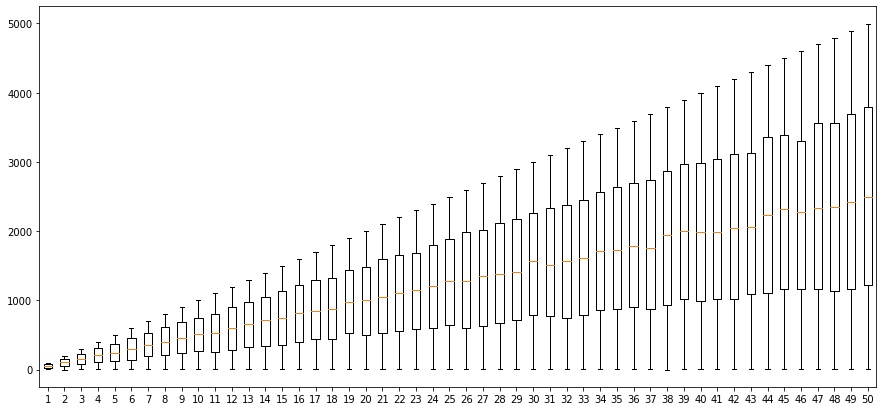

In [167]:
plt.figure(figsize=(15, 7))

data = [x1[i].reshape(-1).numpy() for i in range(50)]

plt.boxplot(data)

plt.show()

**Analysis**:

1. `per_channel` scheme performs better for any range

2. scheme to best-suitable range:

    a) `per_channel` – [-50, 50]

    b) `per_tensor` – [-50, 50]

3. `per-channel` quantization of the weights can improve accuracy, especially when the distribution of weights varies significantly from channel to channel, like we can see on the plot above. IMHO it is connected with the fact, that its easier to transform narrow float sub-range, that the whole tensor's range.

# Task 3 [4 points]

Consider a simple PyTorch model and modify it using QuantStub() and DeQuantStub() to imitate

1) Quantization of all layers

2) Quantization only of convolutionsl layers

Useful links:
- PyTorch model preparation for Quantization https://pytorch.org/docs/stable/quantization.html#model-preparation-for-quantization




## Important PyTorch build-in modules/methods/attributes for Quantization

Below we provide some details on PyTorch build-in tools you need to set the quantization configuration, prepare the model and quantize it.



### QuantStub() and DeQuantStub()

`QuantStub(qconfig)` and `DeQuantStub()` are modules that are swapped to `nnq.Quantize()` and `nnq.DeQuantize()` in `convert()` and perform quantization of activations according to the qconfig.

- `QuantStub, DequantStub` https://github.com/pytorch/pytorch/blob/d5a757959730b5889a5acfe20fb6a932fb58c157/torch/quantization/stubs.py#L4

- `nnq.Quantize, nnq.Dequantize` https://github.com/pytorch/pytorch/blob/4f390eb6b681fa658614789c5c8992c23d40d03b/torch/nn/quantized/modules/__init__.py

If `qconfig = None` nothing happens: output of `QuantStub()` has `float32` format.

If `qconfig.activation.p.keywords['dtype'] == torch.quint8`, then `QuantStub()` peforms quantization of  activations according to the quantization scheme described using `qconfig.activation.p.keywords`.

### prepare()
https://github.com/pytorch/pytorch/blob/9cc44aad21110e7dd481d4d1979c1569059144c2/torch/ao/quantization/quantize.py#L204

Prepares a copy of the model for quantization calibration or quantization-aware training.

Quantization configuration should be assigned preemptively
 to individual submodules in `.qconfig` attribute.

The model will be attached with observer or fake quant modules, and qconfig
 will be propagated.

- get_default_propagation_list() https://github.com/pytorch/pytorch/blob/9cc44aad21110e7dd481d4d1979c1569059144c2/torch/quantization/quantization_mappings.py#L189 Get the default list of module types that we'll attach qconfig
    attribute to in prepare


### convert()
https://github.com/pytorch/pytorch/blob/9cc44aad21110e7dd481d4d1979c1569059144c2/torch/ao/quantization/quantize.py#L446

Converts submodules in the input module to a different module according to `mapping`
    by calling `from_float` method on the target module class

### PyTorch module used for the layer implementation depends on the weights' type and on the computations' type during the propagation. 


**Conv2d**  can be represented using different PyTorch modules:
- nn.Conv2d - float weights 
- nnq.Conv2d - quantized weights, int8 computations (when convolved with uint8 input)
- nnqat.Conv2d - quantized weights, float32 computations (when convolved with uint8 input) => used for QAT training via Fake Quantization

### Module mappings during Quantization

https://github.com/pytorch/pytorch/blob/9cc44aad21110e7dd481d4d1979c1569059144c2/torch/quantization/quantization_mappings.py

When perform quantization, we convert modules that work with float format to modules that work with lower precision format.

Let us see where float modules are mapped during Post Training Quantization by printing PyTorch built-in config. 

Note, that both
- Convolutional layer `torch.nn.modules.conv.Conv2d` 
- Convolutional layer fused with Batch Normalization layer `torch.nn.intrinsic.qat.modules.conv_fused.ConvBn2d`

are converted to `torch.nn.quantized.modules.conv.Conv2d` 

## Demonstrative Example

### Default module mappings 

In [168]:
from torch.quantization.quantization_mappings import DEFAULT_STATIC_QUANT_MODULE_MAPPINGS

# Mappings for Post Training quantization 
# (note that during Quantization Aware Training other quantized modules are used)
DEFAULT_STATIC_QUANT_MODULE_MAPPINGS

{torch.ao.quantization.stubs.DeQuantStub: torch.nn.quantized.modules.DeQuantize,
 torch.ao.quantization.stubs.QuantStub: torch.nn.quantized.modules.Quantize,
 torch.nn.intrinsic.modules.fused.BNReLU2d: torch.nn.intrinsic.quantized.modules.bn_relu.BNReLU2d,
 torch.nn.intrinsic.modules.fused.BNReLU3d: torch.nn.intrinsic.quantized.modules.bn_relu.BNReLU3d,
 torch.nn.intrinsic.modules.fused.ConvReLU1d: torch.nn.intrinsic.quantized.modules.conv_relu.ConvReLU1d,
 torch.nn.intrinsic.modules.fused.ConvReLU2d: torch.nn.intrinsic.quantized.modules.conv_relu.ConvReLU2d,
 torch.nn.intrinsic.modules.fused.ConvReLU3d: torch.nn.intrinsic.quantized.modules.conv_relu.ConvReLU3d,
 torch.nn.intrinsic.modules.fused.LinearReLU: torch.nn.intrinsic.quantized.modules.linear_relu.LinearReLU,
 torch.nn.intrinsic.qat.modules.conv_fused.ConvBn1d: torch.nn.quantized.modules.conv.Conv1d,
 torch.nn.intrinsic.qat.modules.conv_fused.ConvBn2d: torch.nn.quantized.modules.conv.Conv2d,
 torch.nn.intrinsic.qat.modules.conv

### The Model


Assume we have the following PyTorch model.

In [169]:
# Assume we have the following PyTorch model

class MyM(nn.Module):
    def __init__(self):
        super().__init__()
        self.prev_conv = nn.Conv2d(3, 16, 5, 5)
        self.conv = nn.Conv2d(16, 32, 3, 3)
        
    def forward(self, x):
        x = self.prev_conv(x)
        x = self.conv(x)
        
        return x

Let us prepare our model for Quantization https://pytorch.org/docs/stable/quantization.html#model-preparation-for-quantization

We need to wrap modules we will quantize:
- to collect statistics for activations  during calibration step and 
- to perform quantization of activations according to the `qconfig`.

We can do that using 
- either `QuantStub(qconfig)` and `DeQuantStub()`
- or `QuantWrapper`. This case is more convenient, because you don't need to modify `forward()` methods, you can just replace the nn.Module you quantize. 


In [170]:
from torch.quantization import QuantStub, DeQuantStub, QuantWrapper


class MyMQ1(nn.Module):
    def __init__(self):
        super().__init__()
        self.prev_conv = nn.Conv2d(3, 16, 5, 5)

        self.quant = QuantStub()
        self.conv = nn.Conv2d(16, 32, 3, 3)
        self.dequant = DeQuantStub()
        
    def forward(self, x):
        x = self.prev_conv(x)

        x = self.quant(x)
        x = self.conv(x)
        x = self.dequant(x)
        
        return x

class MyMQ2(nn.Module):
    def __init__(self):
        super().__init__()
        self.prev_conv = nn.Conv2d(3, 16, 5, 5)
        self.conv = QuantWrapper(nn.Conv2d(16, 32, 3, 3))
        
    def forward(self, x):
        x = self.prev_conv(x)
        x = self.conv(x)
        
        return x

In [171]:
model = MyMQ1()
model.eval()

MyMQ1(
  (prev_conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(5, 5))
  (quant): QuantStub()
  (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3))
  (dequant): DeQuantStub()
)

In [172]:
model = MyMQ2()
model.eval()

MyMQ2(
  (prev_conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(5, 5))
  (conv): QuantWrapper(
    (quant): QuantStub()
    (dequant): DeQuantStub()
    (module): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3))
  )
)

In [173]:
model = MyM()
model.conv = QuantWrapper(model.conv)
model.eval()

MyM(
  (prev_conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(5, 5))
  (conv): QuantWrapper(
    (quant): QuantStub()
    (dequant): DeQuantStub()
    (module): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3))
  )
)

### QConfig


We need to define how to quantize each nn.Module in our model by initializing its `qconfig`  attribute.

If our module doesn't have `qconfig` attribute, we need to create it.

If `module.qconfig = None` nothing happens during quantization.


In [174]:
def check_qconfig(model):
  for mname, m in model.named_modules():
    print(mname, ': does not have "qconfig" attribute'  if not hasattr(m, 'qconfig') else m.qconfig)

In [175]:
# Initially modules in our model don't have attribute `qconfig`
check_qconfig(model)

# Let define `qconfig=None` for all modules in the model
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

print('\n---\nAfter setting model.qconfig\n---\n')
check_qconfig(model)

 : does not have "qconfig" attribute
prev_conv : does not have "qconfig" attribute
conv : does not have "qconfig" attribute
conv.quant : does not have "qconfig" attribute
conv.dequant : does not have "qconfig" attribute
conv.module : does not have "qconfig" attribute

---
After setting model.qconfig
---

 QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
prev_conv : does not have "qconfig" attribute
conv : does not have "qconfig" attribute
conv.quant : does not have "qconfig" attribute
conv.dequant : does not have "qconfig" attribute
conv.module : does not have "qconfig" attribute


When we run `torch.quantization.prepare(model)`
`qconfig` attribute of a child module is set to the `qconfig` value of its parent module')


In [176]:
torch.quantization.prepare(model, inplace=True)

print('\n---\nAfter preparation. `qconfig` attribute is attached to all childrens\n---\n')
check_qconfig(model)


---
After preparation. `qconfig` attribute is attached to all childrens
---

 QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){'factory_kwargs': <function add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x7f9cb9cb98c0>}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){'factory_kwargs': <function add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x7f9cb9cb98c0>})
prev_conv QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){'factory_kwargs': <function add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x7f9cba11b200>}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symm

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:174: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


### Collecting statistics for Activations Quantization

You should not forget to do this step to get right scale and zero_point dueing quantization!!!

In [177]:
for _ in range(20):
  dummy_input = torch.randn(2, 3, 32, 32)
  _ = model(dummy_input)  

check_qconfig(model)

 QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){'factory_kwargs': <function add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x7f9cb9cb98c0>}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){'factory_kwargs': <function add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x7f9cb9cb98c0>})
prev_conv QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){'factory_kwargs': <function add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x7f9cba11b200>}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){'factory_kwargs': <function add_module_to_qconfig_obs_ctr.<locals>.get_

Finally, let quantize the model

In [178]:
torch.quantization.convert(model, inplace=True)

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:886: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_begin // dst_bin_width, 0, self.dst_nbins - 1
/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:891: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_end // dst_bin_width, 0, s

MyM(
  (prev_conv): QuantizedConv2d(3, 16, kernel_size=(5, 5), stride=(5, 5), scale=0.04000481218099594, zero_point=59)
  (conv): QuantWrapper(
    (quant): Quantize(scale=tensor([0.0400]), zero_point=tensor([59]), dtype=torch.quint8)
    (dequant): DeQuantize()
    (module): QuantizedConv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), scale=0.0188146885484457, zero_point=64)
  )
)

## Your Task

Given a class for a neural network prepare it to be quantizable and quantize.

Namely, you should quantize

1. whole model using default PyTorch static quantization qconfig

2. part of the model


In [179]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p") / 1024**2)
    os.remove('temp.p')

### Fill blanks in `quantize_model` function that performs quantization [1 point]

In [180]:
def quantize_model(model, qconfig_dict={}, input_shape=None):

    print(f'QConfig \n {qconfig_dict}')

    # Layers with qconfig=None will not be quantized
    model.qconfig = None

    for mname, m in model.named_modules():
      if mname in qconfig_dict.keys():
        m.qconfig = qconfig_dict[mname]

    print(f'\n Model before preparation \n{model}')

    # Prepare the model for quantization by propagating qconfig
    
    torch.quantization.prepare(model, inplace=True)
    
    
    print(f'\n Model after preparation & before calibration (activation stats computation) \n{model}')

    # Collect statistics for quantization

    for _ in range(20):
        model(torch.randn(2, 3, 32, 32))
    
    print(f'\n Model after calibration & before conversion \n{model}')

    torch.quantization.convert(model, inplace=True)

    print(f'\n Model after conversion \n{model}')    
    return model

In [181]:
from torchvision.models import vgg16
model = vgg16(pretrained=True)

model.eval()
for p in model.parameters():
  p.requires_grad=False

In [182]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Fuse all possible layers [1 point]

In [183]:
fmodel = copy.deepcopy(model)

# Fuse all possible layers

In [184]:
f_modules_1 = [['0', '1'],
                   ['2', '3'],
                   ['5', '6'],
                   ['7', '8'],
                   ['10', '11'],
                   ['12', '13'],
                   ['14', '15'],
                   ['17', '18'],
                   ['19', '20'],
                   ['21', '22'],
                   ['24', '25'],
                   ['26', '27'],
                   ['28', '29']]

In [185]:
f_modules_2 = [['0', '1'], ['3', '4']]

In [186]:
torch.quantization.fuse_modules(fmodel.features, f_modules_1, inplace=True)

torch.quantization.fuse_modules(fmodel.classifier, f_modules_2, inplace=True)

Sequential(
  (0): LinearReLU(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
  )
  (1): Identity()
  (2): Dropout(p=0.5, inplace=False)
  (3): LinearReLU(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
  )
  (4): Identity()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### Quantize the whole model [1 point]


1. whole model  using default PyTorch static quantization qconfig

In [187]:
# Modify model to be quantizable and set qconfig_dict
qmodel = copy.deepcopy(fmodel)
qmodel = QuantWrapper(qmodel)
qconfig_dict = {'': torch.quantization.get_default_qconfig('fbgemm')}

In [188]:
qmodel = quantize_model(qmodel, qconfig_dict, input_shape=(1, 3, 224, 224))

QConfig 
 {'': QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})}

 Model before preparation 
QuantWrapper(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (module): VGG(
    (features): Sequential(
      (0): ConvReLU2d(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): Identity()
      (2): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (3): Identity()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ConvReLU2d(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (6): Identity()

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:174: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."



 Model after calibration & before conversion 
QuantWrapper(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (dequant): DeQuantStub()
  (module): VGG(
    (features): Sequential(
      (0): ConvReLU2d(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (activation_post_process): HistogramObserver()
      )
      (1): Identity()
      (2): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (activation_post_process): HistogramObserver()
      )
      (3): Identity()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ConvReLU2d(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (activation_post_process): HistogramObserver()
      )
      (6): Identity()
      (7): ConvReLU2d(
        (0): Conv2d(128,

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:886: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_begin // dst_bin_width, 0, self.dst_nbins - 1
/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:891: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_end // dst_bin_width, 0, s


 Model after conversion 
QuantWrapper(
  (quant): Quantize(scale=tensor([0.0683]), zero_point=tensor([62]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (module): VGG(
    (features): Sequential(
      (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.06496402621269226, zero_point=0, padding=(1, 1))
      (1): Identity()
      (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.16896606981754303, zero_point=0, padding=(1, 1))
      (3): Identity()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.24654534459114075, zero_point=0, padding=(1, 1))
      (6): Identity()
      (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.4477006196975708, zero_point=0, padding=(1, 1))
      (8): Identity()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Qua

In [189]:
print_size_of_model(model)
print_size_of_model(qmodel)

Size (MB): 527.8018236160278
Size (MB): 132.21978664398193


In [190]:
# Check inference time
shape = (2, 3, 228, 224)
x = torch.randn(shape)

In [191]:
%timeit _ = model(x)

1 loop, best of 5: 1.02 s per loop


In [192]:
%timeit _ = qmodel(x)

1 loop, best of 5: 628 ms per loop


### Quantize a  part of the model [1 point]

Namely
  - all convolutional layers using Min-Max observers 
  - first fully-connected layer using default PyTorch static quantization qconfig 

In [193]:
fc_list = ['classifier.0']

In [194]:
qmodel = copy.deepcopy(fmodel)

# Modify model to be quantizable and set qconfig_dict
qmodel.features = QuantWrapper(qmodel.features)
qmodel.classifier[0] = QuantWrapper(qmodel.classifier[0])
qconfig_dict = {}

In [195]:
for conv, _ in qmodel.named_modules():
    
    if 'features' in conv:
        qconfig_dict[conv] = torch.quantization.default_qconfig

qconfig_dict[fc_list[0]] = torch.quantization.get_default_qconfig('fbgemm')

In [196]:
# Quantize the model
qmodel = quantize_model(qmodel, qconfig_dict, input_shape=(1, 3, 224, 224))

QConfig 
 {'features': QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){}), 'features.quant': QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){}), 'features.dequant': QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){}), 'features.module': QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, reduce_range=True){}, weight=functools.partial(<class '

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:174: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."



 Model after calibration & before conversion 
VGG(
  (features): QuantWrapper(
    (quant): QuantStub(
      (activation_post_process): MinMaxObserver(min_val=-4.225592136383057, max_val=5.281889915466309)
    )
    (dequant): DeQuantStub()
    (module): Sequential(
      (0): ConvReLU2d(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (activation_post_process): MinMaxObserver(min_val=0.0, max_val=11.145073890686035)
      )
      (1): Identity()
      (2): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (activation_post_process): MinMaxObserver(min_val=0.0, max_val=30.809837341308594)
      )
      (3): Identity()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ConvReLU2d(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
  

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:886: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_begin // dst_bin_width, 0, self.dst_nbins - 1
/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:891: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_end // dst_bin_width, 0, s


 Model after conversion 
VGG(
  (features): QuantWrapper(
    (quant): Quantize(scale=tensor([0.0749]), zero_point=tensor([56]), dtype=torch.quint8)
    (dequant): DeQuantize()
    (module): Sequential(
      (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.08775648474693298, zero_point=0, padding=(1, 1))
      (1): Identity()
      (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.24259714782238007, zero_point=0, padding=(1, 1))
      (3): Identity()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.3222597539424896, zero_point=0, padding=(1, 1))
      (6): Identity()
      (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.5482104420661926, zero_point=0, padding=(1, 1))
      (8): Identity()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): 

In [197]:
print_size_of_model(model)
print_size_of_model(qmodel)

Size (MB): 527.8018236160278
Size (MB): 191.7883596420288


In [198]:
# Check inference time
shape = (2, 3, 228, 224)
x = torch.randn(shape)

In [199]:
%timeit _ = model(x)

1 loop, best of 5: 1.02 s per loop


In [200]:
%timeit _ = qmodel(x)

1 loop, best of 5: 627 ms per loop
